In [68]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [69]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [70]:
import pymc as pm

print(f"Running on PyMC3 v{pm.__version__}")

# observational data
df=pd.DataFrame(columns=['vac','non_vac'])
df["vac"]=[27,7]
df["non_vac"]=[6,1]
df.index =["survive","dead"]
df

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    p_vaccination = pm.Beta("p_vaccination",alpha=1,beta=1)
    p_dying_vaccinated= pm.Beta("p_dying_vaccinated",alpha=1,beta=1)
    p_dying_non_vaccinated= pm.Beta("p_dying_non_vaccinated",alpha=1,beta=1)

    # Obervational likelihoods
    vaccinated = pm.Binomial("vaccinated",n=df["vac"].sum(),p=p_vaccination,observed=df["vac"].sum())
    non_vaccinated = pm.Binomial("non_vaccinated",n=df["non_vac"].sum(),p=1-p_vaccination,observed=df["non_vac"].sum())
    dying_vaccinated = pm.Binomial("dying_vaccinated",n=vaccinated,p=p_dying_vaccinated,observed=df["vac"].loc["dead"])
    dying_non_vaccinated = pm.Binomial("dying_non_vaccinated",n=non_vaccinated,p=p_dying_non_vaccinated,observed=df["non_vac"].loc["dead"])

map_estimate = pm.find_MAP(model=basic_model)
map_estimate
   

Running on PyMC3 v4.3.0


{'p_vaccination_logodds__': array(1.5804497),
 'p_dying_vaccinated_logodds__': array(-1.34992502),
 'p_dying_non_vaccinated_logodds__': array(-1.79176394),
 'p_vaccination': array(0.8292682),
 'p_dying_vaccinated': array(0.20588263),
 'p_dying_non_vaccinated': array(0.1428566)}

In [71]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [p_vaccination]
>Slice: [p_dying_vaccinated]
>Slice: [p_dying_non_vaccinated]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


,mean,sd,hdi_3%,hdi_97%
p_vaccination,0.816,0.058,0.712,0.923
p_dying_vaccinated,0.222,0.068,0.102,0.347
p_dying_non_vaccinated,0.225,0.132,0.010,0.460


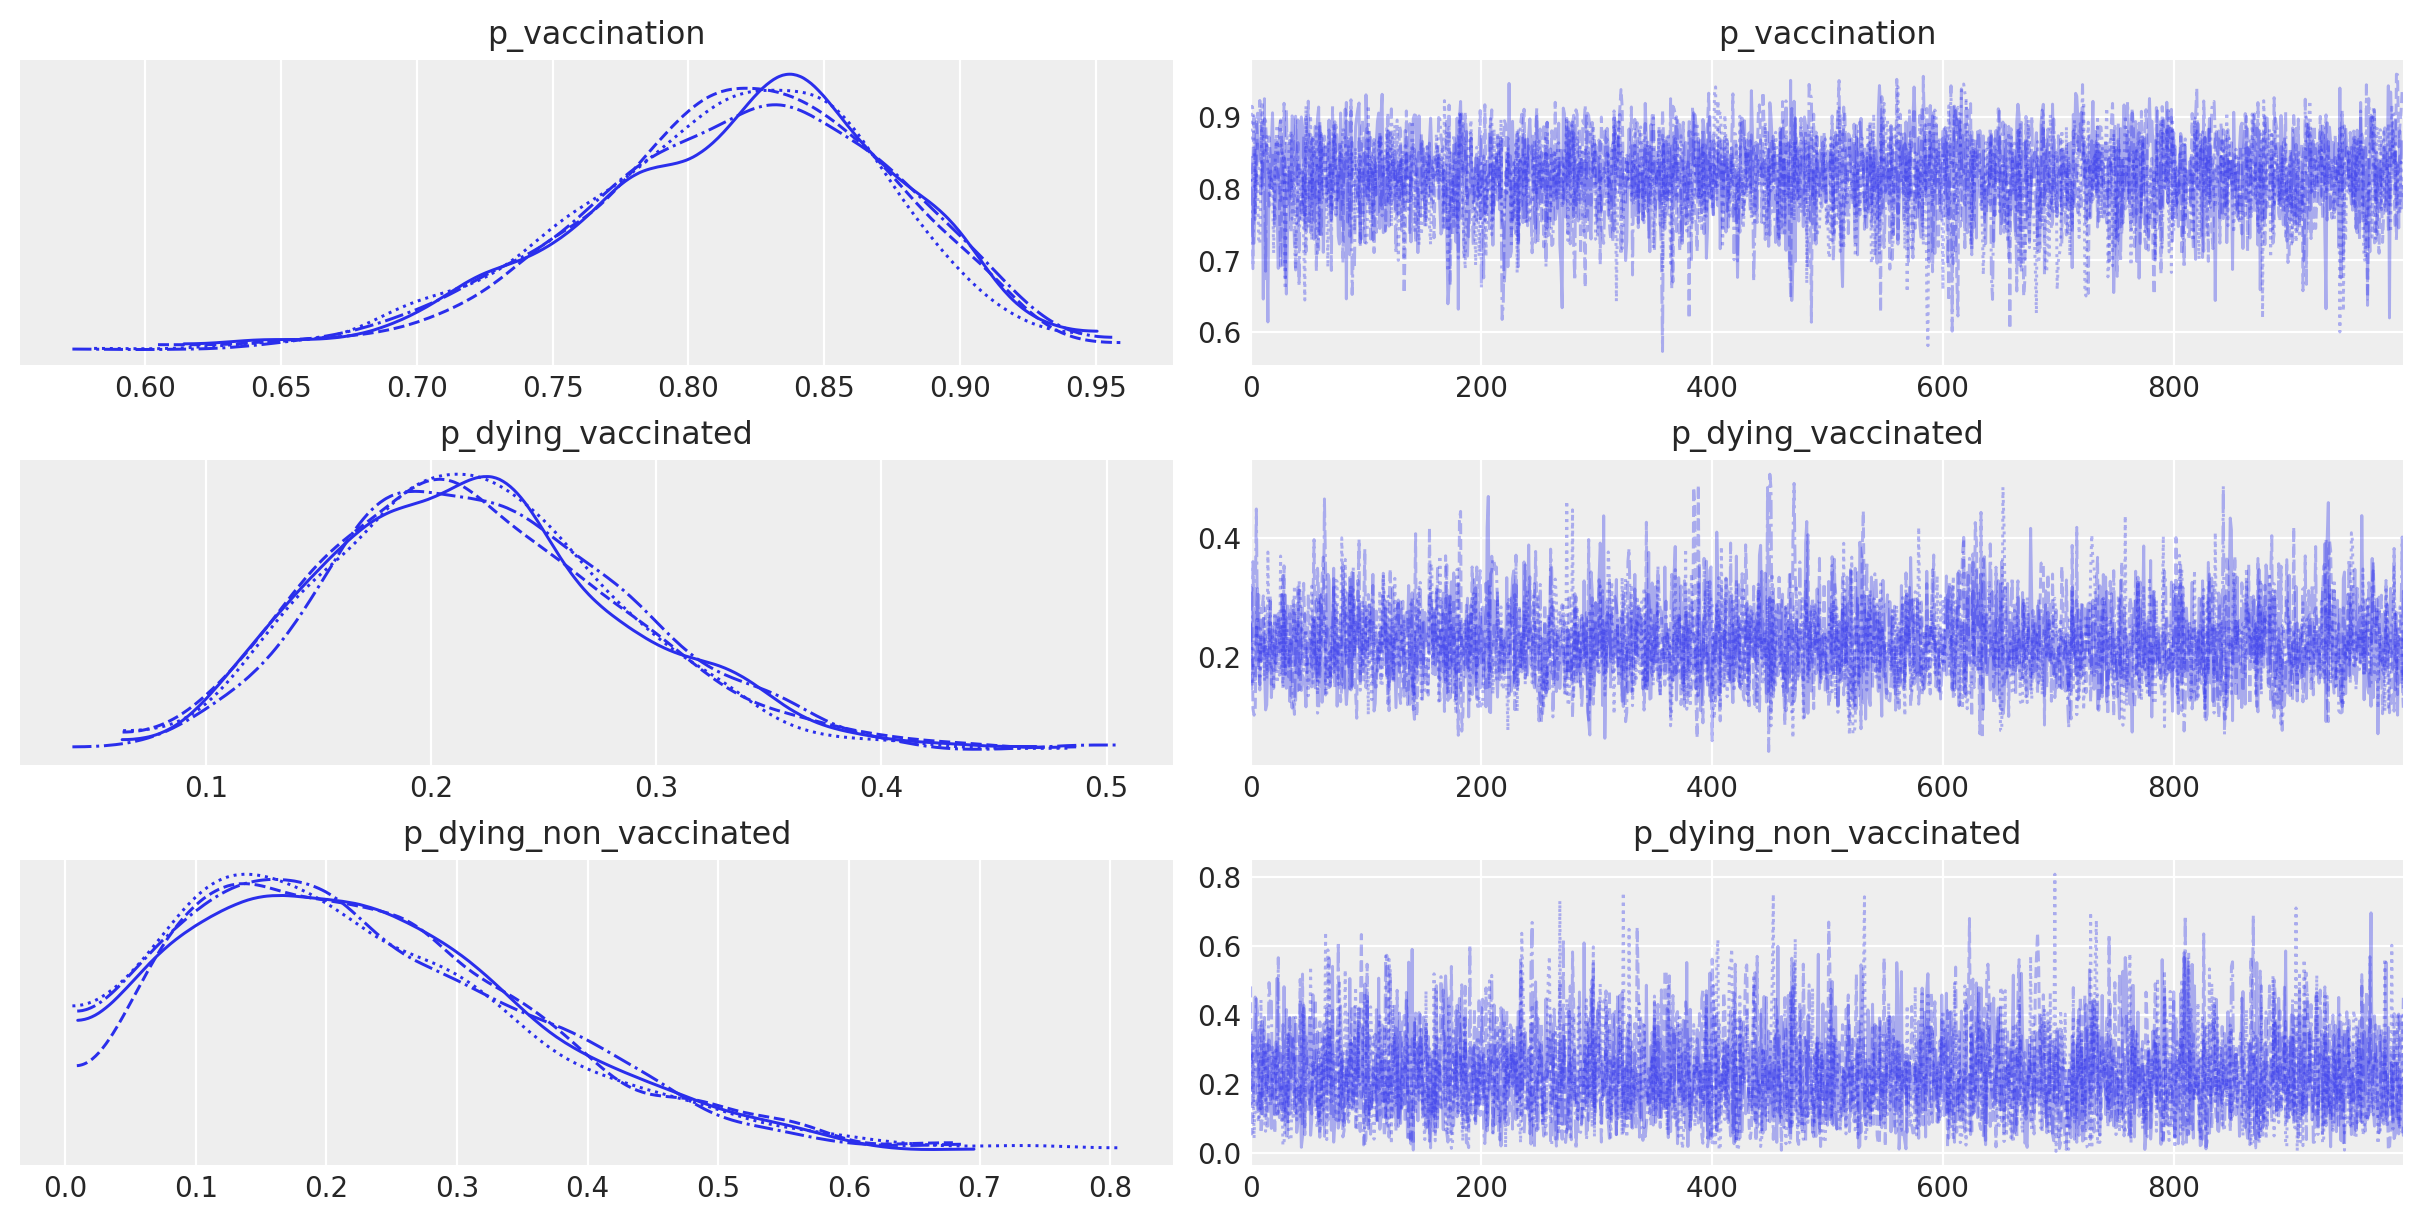

In [72]:
with basic_model:
    az.plot_trace(slice_idata);
az.summary(slice_idata, kind="stats")

### Important: p(I'm going to die) = E[p_dying_vaccinated] =  E[p_dying_non_vaccinated]
A collection of people gets vaxxed or not vaxxed and recieves a p_dying form the conditional distribution. The fraction of people dying will be 22% - no matter the vaxxination status.